# Classifying Consumer Finance Complaints 

## Problem Formulation

- The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning methods are best suited to solve it.
- Given a new complaint comes in, we want to assign it to one of 12 categories. 
- The classifier makes the assumption that each new complaint is assigned to one and only one category.
- This is multi-class text classification problem

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Consumer_Complaints.csv')

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/27/2019,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,NaN,NaN,NAVY FEDERAL CREDIT UNION,NY,11238,NaN,NaN,Web,08/27/2019,In progress,Yes,NaN,3355323
1,08/27/2019,"Credit reporting, credit repair services, or o...",Credit repair services,Confusing or misleading advertising or marketing,NaN,NaN,NaN,FREEDOM FINANCIAL NETWORK,NC,28791,Older American,NaN,Web,08/27/2019,In progress,Yes,NaN,3355527
2,08/27/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,NAVY FEDERAL CREDIT UNION,MA,01523,NaN,NaN,Web,08/27/2019,In progress,Yes,NaN,3354618
3,08/27/2019,"Payday loan, title loan, or personal loan",Installment loan,Charged fees or interest you didn't expect,NaN,NaN,NaN,FREEDOM FINANCIAL NETWORK,CA,95835,Servicemember,NaN,Web,08/27/2019,In progress,Yes,NaN,3355520
4,08/27/2019,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,"NCC Business Services, Inc.",CA,93536,NaN,NaN,Web,08/27/2019,Closed with explanation,Yes,NaN,3355391


**Using Only Consumer Complaint Narrative and Product Columns**

In [4]:
df=df[['Product','Consumer complaint narrative']]
df.rename(columns={"Consumer complaint narrative": "ccNarrative"},inplace=True)

In [5]:
df.isnull().sum()

Product             0
ccNarrative    936468
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

Product        0
ccNarrative    0
dtype: int64

In [8]:
print('There are {} datapoints'.format(df.shape[0]))

There are 432197 datapoints


In [9]:
df['category_id'] = df['Product'].factorize()[0]

In [11]:
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

**Classes are Imbalanced in Data**

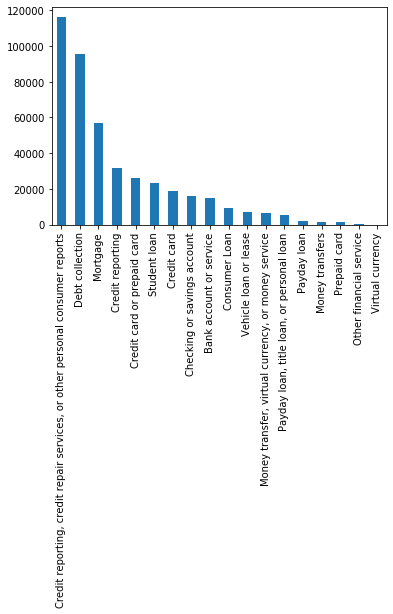

In [26]:
df.Product.value_counts().plot(kind='bar')
plt.show()

In [33]:
for i,j in dict(df['Product'].value_counts()).items():
    print('{} : {} Complaints ( {} %)'.format(i,j,np.round((j*1.0/df.shape[0]*1.0)*100),3))
    print('--'*60)

Credit reporting, credit repair services, or other personal consumer reports : 116041 Complaints ( 27.0 %)
------------------------------------------------------------------------------------------------------------------------
Debt collection : 95680 Complaints ( 22.0 %)
------------------------------------------------------------------------------------------------------------------------
Mortgage : 56866 Complaints ( 13.0 %)
------------------------------------------------------------------------------------------------------------------------
Credit reporting : 31588 Complaints ( 7.0 %)
------------------------------------------------------------------------------------------------------------------------
Credit card or prepaid card : 26193 Complaints ( 6.0 %)
------------------------------------------------------------------------------------------------------------------------
Student loan : 23363 Complaints ( 5.0 %)
---------------------------------------------------------------

## Train Test Split 

In [21]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(df[['ccNarrative','Product']],df['category_id'],test_size=0.2,stratify=df['category_id'])

In [22]:
print('Train Size:',xtrain.shape[0],'\nTest Size:',xtest.shape[0])

Train Size: 345757 
Test Size: 86440


### Distribution of Class Labels in Train and Test Data
**Train Data**

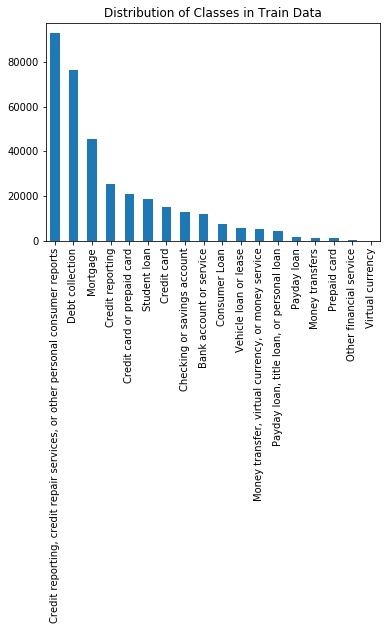

In [24]:
xtrain.Product.value_counts().plot(kind='bar')
plt.title('Distribution of Classes in Train Data')
plt.show()

In [29]:
for i,j in dict(xtrain['Product'].value_counts()).items():
    print('{} : {} Complaints ( {} %)'.format(i,j,np.round((j*1.0/xtrain.shape[0]*1.0)*100),3))
    print('--'*60)

Credit reporting, credit repair services, or other personal consumer reports : 92833 Complaints ( 27.0 %)
------------------------------------------------------------------------------------------------------------------------
Debt collection : 76544 Complaints ( 22.0 %)
------------------------------------------------------------------------------------------------------------------------
Mortgage : 45493 Complaints ( 13.0 %)
------------------------------------------------------------------------------------------------------------------------
Credit reporting : 25270 Complaints ( 7.0 %)
------------------------------------------------------------------------------------------------------------------------
Credit card or prepaid card : 20954 Complaints ( 6.0 %)
------------------------------------------------------------------------------------------------------------------------
Student loan : 18690 Complaints ( 5.0 %)
----------------------------------------------------------------

**Test Data**

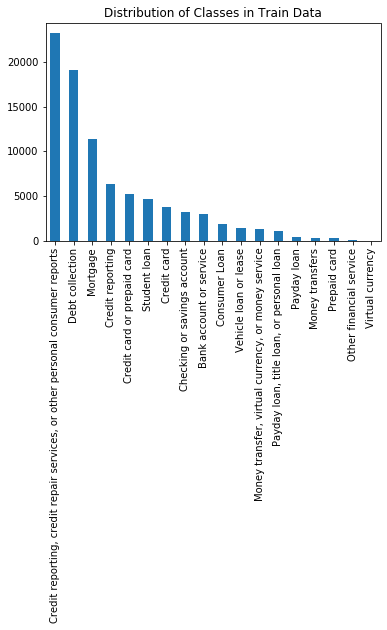

In [26]:
xtest.Product.value_counts().plot(kind='bar')
plt.title('Distribution of Classes in Train Data')
plt.show()

In [31]:
for i,j in dict(xtest['Product'].value_counts()).items():
    print('{} : {} Complaints ( {} %)'.format(i,j,np.round((j*1.0/xtest.shape[0]*1.0)*100),3))
    print('--'*60)

Credit reporting, credit repair services, or other personal consumer reports : 23208 Complaints ( 27.0 %)
------------------------------------------------------------------------------------------------------------------------
Debt collection : 19136 Complaints ( 22.0 %)
------------------------------------------------------------------------------------------------------------------------
Mortgage : 11373 Complaints ( 13.0 %)
------------------------------------------------------------------------------------------------------------------------
Credit reporting : 6318 Complaints ( 7.0 %)
------------------------------------------------------------------------------------------------------------------------
Credit card or prepaid card : 5239 Complaints ( 6.0 %)
------------------------------------------------------------------------------------------------------------------------
Student loan : 4673 Complaints ( 5.0 %)
-------------------------------------------------------------------

### Using tfidf to featurise Text Data

In [60]:
%%time

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features_train = tfidf.fit_transform(xtrain.ccNarrative)
features_test=tfidf.transform(xtest.ccNarrative)

Wall time: 2min 30s


In [62]:
print(features_test.shape,features_train.shape)

(86440, 661913) (345757, 661913)


In [41]:
labels = ytrain

In [47]:
feature_names = tfidf.get_feature_names()
def returndoc():
    doc = 0
    feature_index = features[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [features[doc, x] for x in feature_index])

    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
          print(w, s)

victim 0.05533985538574123
mortgage 0.07212629371801511
fraud 0.0630398586020168
trying 0.02491281473568566
resolve 0.029921306771465803
2008 0.08761672563471952
able 0.025459932265072413
received 0.016945578221415594
xxxx 0.041795152272992804
stating 0.02513135738555662
representative 0.027645757736369864
country 0.04377482833571088
wide 0.059496429494659435
helped 0.07866207164215296
customers 0.03488061341515623
problems 0.036695964767555815
refinancing 0.0455883918604702
homes 0.0479757572347309
understanding 0.038945155438001464
refinance 0.0625213855844457
home 0.06725271097321359
terms 0.033762012184102755
suitable 0.06318772233189522
agreed 0.030365886500058278
meetings 0.06582110656089302
later 0.0443806607152606
told 0.03750169470214546
benefit 0.04432513121716371
special 0.09840354457670193
financing 0.09134144539159676
program 0.03484643958336467
way 0.02697586051244508
remain 0.04060928433227572
lower 0.03600318196215777
payment 0.01822136840064411
did 0.04296110069232443


In [43]:
data_struct = {'vectorizer': tfidf, 'features':features }
with open('storage.bin', 'wb') as f: 
    pickle.dump(data_struct, f)

In [33]:
#load
with open('storage.bin', 'rb') as f:
    data_struct = pickle.load(f)
    tfidf, features = data_struct['vectorizer'], data_struct['features']

### Using chi2 to find the terms that are the most correlated with each of the products

In [50]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# {}:".format(Product))
  print("  Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. bank
. overdraft
  . Most correlated bigrams:
. overdraft fees
. checking account
# 'Checking or savings account':
  . Most correlated unigrams:
. checking
. deposit
  . Most correlated bigrams:
. savings account
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. vehicle
. car
  . Most correlated bigrams:
. santander consumer
. auto loan
# 'Credit card':
  . Most correlated unigrams:
. macy
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. express
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. equifax
. experian
  . Most correlated bigrams:
. manner soon
. disputed resolve
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. inquiries
. equifax
  . Most correlated bigrams:
. mistakes appear

## Naive Bayes

In [83]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(features_train, ytrain)

In [97]:
y_pred = clf.predict(features_test) 

In [99]:
from sklearn import metrics
print(metrics.classification_report(ytest, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.60      0.91      0.72     23208
                                                             Debt collection       0.64      0.85      0.73     19136
                                                                    Mortgage       0.65      0.94      0.77     11373
                                   Payday loan, title loan, or personal loan       0.00      0.00      0.00      1052
                                                 Credit card or prepaid card       0.49      0.39      0.43      5239
                                                 Checking or savings account       0.63      0.25      0.36      3147
                                                                Student loan       0.95      0.53      0.68      4673
                                                       

**Accuracy is 0.63 , But 8 Classes have 0 Precision and Recall**

## Logistic Regression

In [103]:
%%time

clf=LogisticRegression().fit(features_train,ytrain)

In [105]:
y_pred = clf.predict(features_test)
print(metrics.classification_report(ytest, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.76      0.87      0.81     23208
                                                             Debt collection       0.79      0.88      0.83     19136
                                                                    Mortgage       0.89      0.95      0.92     11373
                                   Payday loan, title loan, or personal loan       0.57      0.32      0.41      1052
                                                 Credit card or prepaid card       0.65      0.70      0.67      5239
                                                 Checking or savings account       0.69      0.68      0.68      3147
                                                                Student loan       0.87      0.86      0.87      4673
                                                       

**Accuracy is 0.77 ,But 2 Classes have 0 Precision and Recall** 

## Linear SVC

In [106]:
%%time

clf=LinearSVC().fit(features_train,ytrain)

Wall time: 1min 46s


In [107]:
y_pred = clf.predict(features_test)
print(metrics.classification_report(ytest, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.82      0.88      0.85     23208
                                                             Debt collection       0.83      0.88      0.85     19136
                                                                    Mortgage       0.91      0.96      0.93     11373
                                   Payday loan, title loan, or personal loan       0.58      0.38      0.46      1052
                                                 Credit card or prepaid card       0.66      0.68      0.67      5239
                                                 Checking or savings account       0.66      0.68      0.67      3147
                                                                Student loan       0.89      0.88      0.88      4673
                                                       

**Accuracy is 0.79 ,Non Zero Precision and Recall**

## XGBoost

In [112]:
dtrain = xgb.DMatrix(data=features_train, label=ytrain)
dtest = xgb.DMatrix(data=features_test)

In [115]:
params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 18}

In [116]:
%%time
bst = xgb.train(params, dtrain)

Wall time: 12min 33s


In [117]:
pred = bst.predict(dtest)

In [123]:
print(metrics.classification_report(ytest, pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.64      0.82      0.72     23208
                                                             Debt collection       0.73      0.80      0.76     19136
                                                                    Mortgage       0.87      0.90      0.88     11373
                                   Payday loan, title loan, or personal loan       0.46      0.22      0.30      1052
                                                 Credit card or prepaid card       0.60      0.53      0.56      5239
                                                 Checking or savings account       0.56      0.54      0.55      3147
                                                                Student loan       0.82      0.81      0.82      4673
                                                       

**Accuracy is 0.69 , But 1 class have 0.0 Precision and Recall**

In [127]:
from prettytable import PrettyTable
x = PrettyTable()
print ("Accuracy table")
x.field_names = ["Model","Accuracy", "Precision and Recall"]
x.add_row(["Naive Bayes", 0.63,8])
x.add_row(["Linear Regression", 0.77,2])
x.add_row(["Linear SVC", 0.79,0])
x.add_row(["XgBoost ", 0.69,1])
print(x)

Accuracy table
+-------------------+----------+----------------------+
|       Model       | Accuracy | Precision and Recall |
+-------------------+----------+----------------------+
|    Naive Bayes    |   0.63   |          8           |
| Linear Regression |   0.77   |          2           |
|     Linear SVC    |   0.79   |          0           |
|      XgBoost      |   0.69   |          1           |
+-------------------+----------+----------------------+


**Best Model is Linear SVC**